##### Author : 김재현
##### Created : 2021-06-23
##### Description : 기능에 따라 해당 코드의 관련 정보를 확인 및 시각화. MACD, OSC 값을 기준으로 판단한다.
##### 
##### 
##### 1. 기능
##### seeAll = 4개월간 이동평균선이 상승국면에 있으나 1달간 단기 하락중인 종목 코드 리스트업
##### select = 배당을 비롯한 세부정보 및 차트 제공 ** 해당 기능은 현재 미국 주식만 가능
##### 
##### 2. 참고링크
##### https://md2biz.tistory.com/397 각종 지표별 의미
##### https://nakyup.tistory.com/5 각종 지표 가공
##### https://m.blog.naver.com/silvury/221312883764 배당정보 크로울링

In [1]:
# 필요한 라이브러리

import FinanceDataReader as web
import pandas_datareader.data as pdweb
from datetime import date, timedelta
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import time

import csv
import urllib
from bs4 import BeautifulSoup as bs

from PIL import Image as pl

%matplotlib inline

want to decide your settings? it will create data automatically.(y/n)


 y



market list : 
KRX(한국전체), KOSPI(코스피전체), KOSDAQ(코스닥전체), KONEX(코넥스전체) - 배당 구현중
NASDAQ(나스닥종목), NYSE(뉴욕증권거래소), AMEX(AMEX종목), SP500(S&P500 종목)

'dayago' decieds your startday to crawl data. it needs to set 'dayago' at least 120. (1 year recommanded.)

set your target market.


 NASDAQ


set your 'dayago'.


 360


set result length.


 5



**** Data has been set. make sure ur market. if it doesn't match with the list above, then it will occur some errors. ****

market :  NASDAQ
startday(dayago) :  2020-06-28 ( 360 )
result length :  5

loading entire stockcode data from market..

list already exists, proceed to next steps.
select ur menus.

seeAll = show all stock datas of market which u selected.
search = search some stocks which you want, it will show charts and recent dividend infos.


 search


input ur target stock code.


 AAPL


you just searched  AAPL ,
drawing complete.
['selected stock code : ', 'AAPL', 'long-term in stock prices : rise', 'short-term in stock prices : rise', None]


KeyboardInterrupt: Interrupted by user

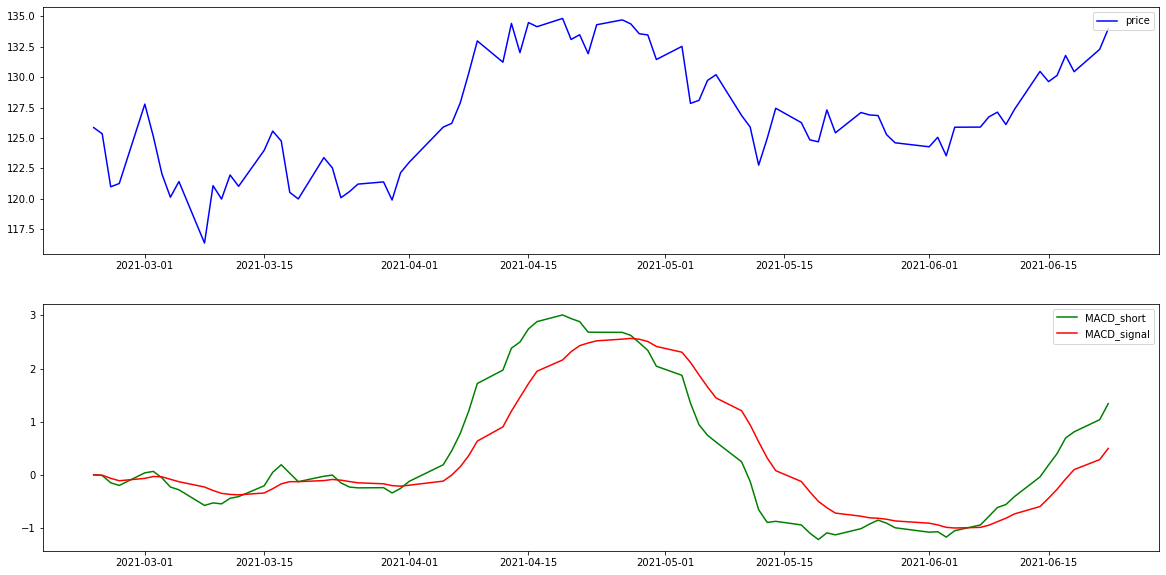

In [28]:
# 필요값 (전역변수) 및 실행

market = ""
today = date.today()
startday = date.today() - timedelta(360)
yesterday = date.today() - timedelta(1)
trigger = 0
allResStr = ["recommanded stocks : "]
schResStr = ["selected stock code : "]
resChart = plt
SEC = web
stockCode = ""

main()

In [14]:
# 전체 가동 코드

def main():

    print("want to decide your settings? it will create data automatically.(y/n)")

    while(True):
        menubtn = input()
        print("")
        if menubtn == "y":
            settings()
            time.sleep(3)
            create_data(market)
            break
        elif menubtn == "n":
            break
        else:
            print("selected wrong button, want to decide your settings?(y/n)")

    print("select ur menus.")
    print("")
    print("seeAll = show all stock datas of market which u selected.")
    print("search = search some stocks which you want, it will show charts and recent dividend infos.")

    while(True):
        menubtn = input()
        if menubtn == "seeAll":
            get_recommanded(trigger)
            print(allResStr)
        elif menubtn == "search":
            get_searched()
            print(schResStr)
            chart = pl.open('./chartSet/searchedChart_' + str(stockCode) + '.png')
            chart.show()
        else:
            print("you just selected wrong menu.")
            print("")

In [3]:
# seeAll - 기본 클래스
# trigger에 설정된 수만큼 조건에 맞는 회사의 코드를 리턴한다.

def get_recommanded(trigger):
    
    codefilename = './stockDataSet/marketList_' + str(market) + '.csv'
    count = 0
    global allResStr

    try:
        with open(codefilename, 'r', newline='') as file:
            print("loading entire data complete.")

            codefilename = pd.read_csv("./stockDataSet/marketList_NASDAQ.csv")
            symbolList = codefilename.loc[:, "Symbol"]
        
        for i in range (0, len(symbolList)):

            SEC = web.DataReader(symbolList[i], startday, yesterday).reset_index()
            SEC["MA_12"]=SEC["Close"].ewm(span=12).mean()
            SEC["MA_26"]=SEC["Close"].ewm(span=26).mean()
            SEC["MA_50"]=SEC["Close"].ewm(span=50).mean()
            SEC["MA_120"]=SEC["Close"].ewm(span=120).mean()
            SEC["MACD_long"] = SEC.apply(lambda x: (x["MA_50"]-x["MA_120"]), axis=1)
            SEC["MACD_short"] = SEC.apply(lambda x: (x["MA_12"]-x["MA_26"]), axis=1)
            SEC["MACD_signal"] = SEC["MACD_short"].ewm(span=9).mean()
            SEC["MACD_oscillator"] = SEC.apply(lambda x:(x["MACD_short"]-x["MACD_signal"]), axis=1)

            # 비교대상 값 불러옴 - MACD, 오늘 기준 OSC, 3일 전 OSC
            resList = [float(SEC.loc[len(SEC)-1:len(SEC), "MACD_long"]), 
                       float(SEC.loc[len(SEC)-1:len(SEC), "MACD_oscillator"])]
            print(trigger)
            print(count)
            if (resList[0] > 0):
                
                if (resList[1] < 0):
                    allResStr.append(symbolList[i] + ", ")
                    count += 1
                    print(symbolList[i], "appended++")
                    
                    if (count == int(trigger)):
                        break

    except:
        print("loading error occured, restart session and reset your settings.")

In [27]:
# search - 검색 주식 정보 출력
def get_searched():
    
    global schResStr
    global startday
    global yesterday
    global SEC
    global stockCode

    startday = date.today() - timedelta(120)

    print("input ur target stock code.")
    stockCode = input()

    print("you just searched ", stockCode, ",")

    try:
        SEC = web.DataReader(stockCode, startday, yesterday)

    except:
        print("your stock code doesn't exist in List.")

    schResStr.append(stockCode)
    SEC["MA_12"]=SEC["Close"].ewm(span=12).mean()
    SEC["MA_26"]=SEC["Close"].ewm(span=26).mean()
    SEC["MA_50"]=SEC["Close"].ewm(span=50).mean()
    SEC["MA_120"]=SEC["Close"].ewm(span=120).mean()
    SEC["MACD_long"] = SEC.apply(lambda x: (x["MA_50"]-x["MA_120"]), axis=1)
    SEC["MACD_short"] = SEC.apply(lambda x: (x["MA_12"]-x["MA_26"]), axis=1)
    SEC["MACD_signal"] = SEC["MACD_short"].ewm(span=9).mean()
    SEC["MACD_oscillator"] = SEC.apply(lambda x:(x["MACD_short"]-x["MACD_signal"]), axis=1)

    # 차트 형성
    get_draw_selected(stockCode, SEC)

    # 마지막 행의 값을 추출하기 위해 인덱스 리셋
    SEC = SEC.reset_index()

    resList = [float(SEC.loc[len(SEC)-1:len(SEC), "MACD_long"]), 
                float(SEC.loc[len(SEC)-1:len(SEC), "MACD_oscillator"])]

    if (resList[0] < 0):
        schResStr.append("long-term in stock prices : decline")
    else:
        schResStr.append("long-term in stock prices : rise")

    if (resList[1] < 0):
        schResStr.append("short-term in stock prices : decline")
    else:
        schResStr.append("short-term in stock prices : rise")
        
    # 배당정보 형성
        
    schResStr.append(get_dividend_data(stockCode))

In [5]:
# search - 차트 도식 및 저장
def get_draw_selected(stockCode, SEC):
    
    try:
        fig = plt.figure(figsize = (20, 10))

        x = SEC.index
        y = SEC['Close']
        y2 = SEC['MACD_short']
        y3 = SEC['MACD_signal']

        ax1 = fig.add_subplot(2,1,1)
        ax2 = fig.add_subplot(2,1,2)

        ax1.plot(x, y, "b", label = "price")
        ax1.legend(loc = 1)
        ax2.plot(x, y2, "g", label = "MACD_short")
        ax2.plot(x, y3, "r", label = "MACD_signal")
        ax2.legend(loc = 1)

        plt.savefig('./chartSet/searchedChart_' + str(stockCode) + '.png')
        print("drawing complete.")

    except:
        print("drawing error.")

In [6]:
# search - 배당정보 형성 클래스 생성

def set_dividend_data(stockCode):
    
    divdata = []
    url = "https://finance.yahoo.com/quote/" + stockCode + "?p=" + stockCode
    rows = bs(urllib.request.urlopen(url).read()).findAll('table')[1].tbody.findAll('tr')

    for i in rows:
        divs = i.findAll('td')
        if 'Forward Dividend' in str(divs[0]):
            div_and_yield = divs[1].text
            dividend, div_yield = div_and_yield.split(" ")
            a = div_yield.replace("(","")
            b = a.replace(")","")
            divdata.append([float(dividend), str(b)])
    return divdata

In [29]:
# search - 배당정보 appender

def get_dividend_data(stockCode):
    
    rows = []
    df = pdweb.DataReader(stockCode, 'yahoo', startday, yesterday)
    dividend_data = set_dividend_data(stockCode)
    row = [stockCode, dividend_data[0][0], dividend_data[0][1], round(float(df.iloc[-1][0]),2)]
    rows.append(row)

In [8]:
# 가동일 기준 데이터를 로드, 스톡리스트를 생성해줄 클래스 생성

def create_data(market):
    
    codefilename = './stockDataSet/marketList_' + str(market) + '.csv'
    
    # 목표 시장 선택 및 데이터 로드
    print("loading entire stockcode data from market..")
    print("")
    try:
        # file 존재여부 확인
        with open(codefilename, 'r', newline='') as file:
            print("list already exists, proceed to next steps.")
    except:
        try:
            print("")
            print("list none-exists. load marketList which you requested.")
            targetMarket = web.StockListing(market)
            print("loading complete. making lists..")
            print("")

            targetMarket.to_csv('./stockDataSet/marketList_' + str(market) + '.csv')
            print("list created, initialize to next steps.")

        except:
            time.sleep(3)
            print("")
            print("loading error occured, please try again or check ur status.")

In [9]:
# 기본값 입력받을 클래스
def settings():
    
    print("market list : ")
    print("KRX(한국전체), KOSPI(코스피전체), KOSDAQ(코스닥전체), KONEX(코넥스전체) - 배당 구현중")
    print("NASDAQ(나스닥종목), NYSE(뉴욕증권거래소), AMEX(AMEX종목), SP500(S&P500 종목)")
    print("")
    print("'dayago' decieds your startday to crawl data. it needs to set 'dayago' at least 120. (1 year recommanded.)")
    print("")

    
    print("set your target market.")
    global market
    market = input()
    
    print("set your 'dayago'.")
    dayago = input()
    
    print("set result length.")
    global trigger
    trigger = input()

    global startday
    startday = date.today() - timedelta(int(dayago))
        
    print("")
    print("**** Data has been set. make sure ur market. if it doesn't match with the list above, then it will occur some errors. ****")
    print("")

    print("market : ", market)
    print("startday(dayago) : ", startday, "(", dayago, ")")
    print("result length : ", trigger)
    print("")